# Init

**Notebook 1: Data Exploration**

This notebook loads the Beer Reviews dataset from Kaggle, and performs initial exploration of the data.

In [1]:
# Import required libraries for data manipulation and visualization
import kagglehub
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

/Users/Kitsuragi/Desktop/Code/Brewtiful/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download the Beer Reviews dataset from Kaggle
# Contains 1,586,614 reviews across 66,055 beers from 33,387 users
path = kagglehub.dataset_download("rdoume/beerreviews", path='beer_reviews.csv', force_download = True)
beer = pd.read_csv(path)

100%|██████████| 27.4M/27.4M [00:00<00:00, 56.5MB/s]

Extracting zip of beer_reviews.csv...


### Dataset Overview

The Beer Reviews dataset contains **1,586,614 reviews** from a beer enthusiast community:

This popular dataset has been used as a benchmark for multiple projects/papers.

In [3]:
# 1586614 rows, each representing a beer review with 13 variables
beer.shape

(1586614, 13)

In [4]:
# There are multiple columns representing different review aspects
# There is also some metadata about the beer and a timestamp
beer.columns

Index(['brewery_id', 'brewery_name', 'review_time', 'review_overall',
       'review_aroma', 'review_appearance', 'review_profilename', 'beer_style',
       'review_palate', 'review_taste', 'beer_name', 'beer_abv',
       'beer_beerid'],
      dtype='object')

My scraped dataset does not contain detailed review information - only the overall rating. Therefore, we won't analyze the different rating categories for the purpose of this exploration.

In [5]:
# Drop detailed review attributes - we only need overall ratings for collaborative filtering
# Removes aroma, appearance, palate, and taste scores to focus on overall rating
beer.drop(columns=['review_aroma', 'review_appearance', 'review_palate', 'review_taste'], inplace=True)

In [6]:
# Rename columns to reflect the same names as in production dataset
beer.rename(columns={'review_overall': 'rating',
                     'review_profilename': 'user',
                     'beer_style': 'style',
                     'beer_abv': 'ABV',
                     'beer_beerid': 'beer_id',
                     'brewery_name': 'brewery',
                     'review_time': 'date'}, 
                     inplace=True)

In [7]:
# Save kaggle data to parquet format for efficient loading
beer.to_parquet('data/reviews.parquet', engine='pyarrow', index=False)

# Data Validation

Validate data quality, identify missing values, and check for duplicates.

In [8]:
# Load the reformatted dataset
import pandas as pd
reviews = pd.read_parquet('data/reviews.parquet', engine='pyarrow')


In [9]:
# Sanity check
reviews.shape

(1586614, 9)

Dataset features:
- **66,055 unique beers** from 5,840 breweries
- **33,387 users** contributing reviews
- **104 beer styles** across many categories
- Reviews span **5.5 years** (2006-2012)

In [10]:
reviews.nunique()

brewery_id       5840
brewery          5742
date          1577960
rating             10
user            33387
style             104
beer_name       56857
ABV               530
beer_id         66055
dtype: int64

In [11]:
# display first 5 reviews
reviews.head()

,brewery_id,brewery,date,rating,user,style,beer_name,ABV,beer_id
0,10325,Vecchio Birraio,1234817823,1.5,stcules,Hefeweizen,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,stcules,English Strong Ale,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,stcules,Foreign / Export Stout,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,stcules,German Pilsener,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,johnmichaelsen,American Double / Imperial IPA,Cauldron DIPA,7.7,64883


In [12]:
# Check for missing values
# Key findings: 67,785 beers missing ABV (~4%), 348 missing usernames, 15 missing breweries
reviews.isnull().sum()

brewery_id        0
brewery          15
date              0
rating            0
user            348
style             0
beer_name         0
ABV           67785
beer_id           0
dtype: int64

In [13]:
# Check for duplicate reviews by same user for same beer (ignoring timestamp)
# Result: 14,806 duplicate user-beer pairs - users reviewed same beer multiple times
reviews.duplicated(subset=['user', 'beer_id']).sum()

np.int64(14806)

In [14]:
# Check for exact duplicates including timestamp - only 7 exact duplicates
reviews.duplicated(subset=['user', 'beer_id', 'date']).sum()

np.int64(7)

In [15]:
# Check date range of reviews (Unix timestamps)
# Reviews span from Aug 1996 to Jan 2012 (~5.5 years of data)
print(pd.to_datetime(reviews['date'].min(), unit='s'), pd.to_datetime(reviews['date'].max(), unit='s'))

1996-08-22 00:00:01 2012-01-11 12:35:48


# EDA

Exploratory Data Analysis to understand sparsity, user/item distributions, and filtering requirements.

In [16]:
# Rating distribution statistics
# Mean rating: 3.82/5.0 - users tend to rate positively (selection bias)
# Median: 4.0, showing skew toward higher ratings
reviews['rating'].describe()

count    1.586614e+06
mean     3.815581e+00
std      7.206219e-01
min      0.000000e+00
25%      3.500000e+00
50%      4.000000e+00
75%      4.500000e+00
max      5.000000e+00
Name: rating, dtype: float64

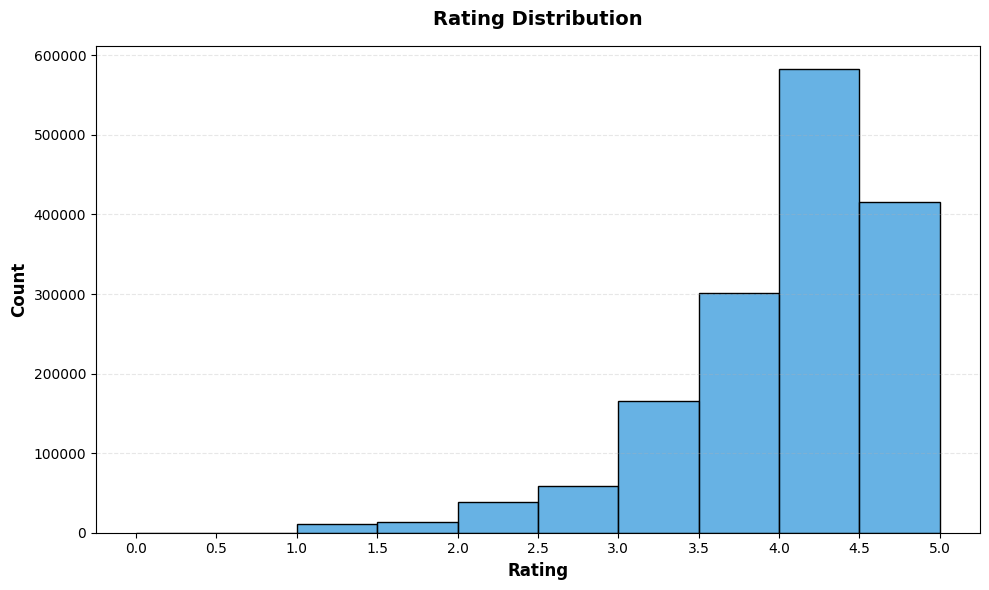

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(reviews['rating'], bins=10, kde=False, color='#3498db', edgecolor='black')
plt.xlabel('Rating', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Rating Distribution', fontsize=14, fontweight='bold', pad=15)
plt.xticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.grid(True, alpha=0.3, linestyle='--', axis='y')
plt.tight_layout()

In [18]:
# User activity distribution
# Mean: 47.5 reviews/user, Median: 3 reviews
# Highly skewed - most users have few reviews, some power users have thousands
reviews.groupby('user').size().describe()

count    33387.000000
mean        47.511487
std        182.599759
min          1.000000
25%          1.000000
50%          3.000000
75%         16.000000
max       5817.000000
dtype: float64

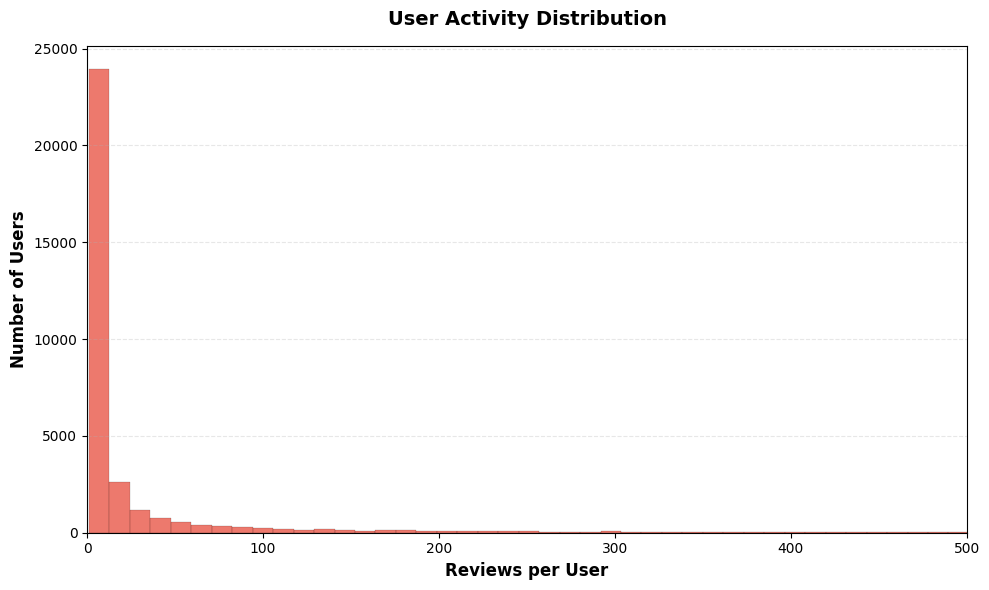

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(reviews.groupby('user').size(), bins=500, kde=False, color='#e74c3c', edgecolor='black')
plt.xlabel('Reviews per User', fontsize=12, fontweight='bold')
plt.ylabel('Number of Users', fontsize=12, fontweight='bold')
plt.title('User Activity Distribution', fontsize=14, fontweight='bold', pad=15)
plt.xlim(0, 500)
plt.grid(True, alpha=0.3, linestyle='--', axis='y')
plt.tight_layout()

In [20]:
# Beer popularity distribution
# Mean: 24 reviews/beer, Median: 2 reviews
# Long tail distribution - few popular beers, many obscure ones
reviews.groupby('beer_id').size().describe()

count    66055.000000
mean        24.019590
std        110.864191
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max       3290.000000
dtype: float64

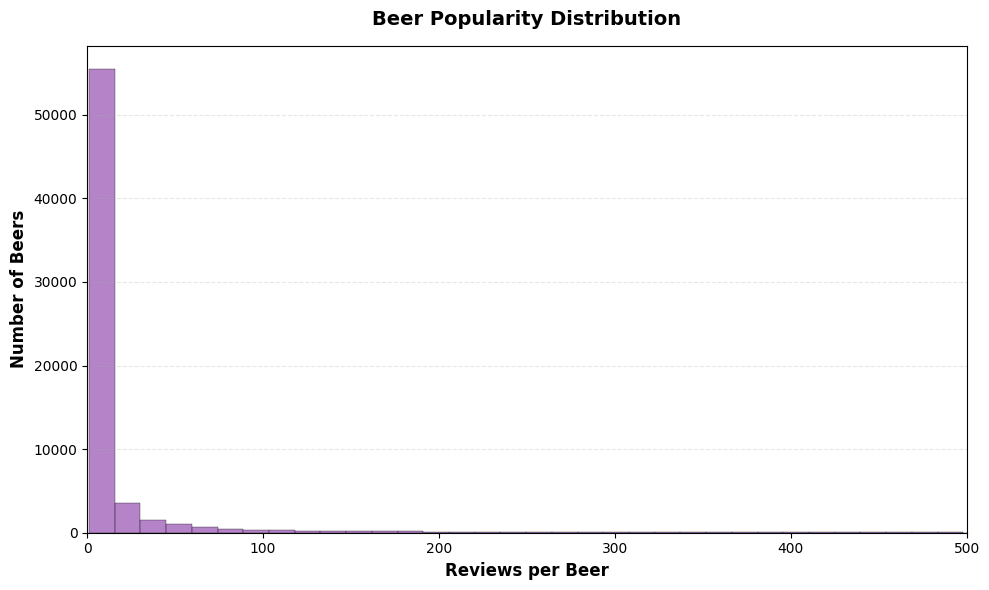

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(reviews.groupby('beer_id').size(), bins=225, kde=False, color='#9b59b6', edgecolor='black')
plt.xlabel('Reviews per Beer', fontsize=12, fontweight='bold')
plt.ylabel('Number of Beers', fontsize=12, fontweight='bold')
plt.title('Beer Popularity Distribution', fontsize=14, fontweight='bold', pad=15)
plt.xlim(0, 500)
plt.grid(True, alpha=0.3, linestyle='--', axis='y')
plt.tight_layout()

### Sparsity Challenge

The interaction matrix has **0.072% density** - extremely sparse! This is typical for recommender systems:
- Most users have very few reviews, bulk of reviews in the dataset come from power users
- Most beers have very few reviews, bulk of reviews in the dataset come from highly popular items

In other words: there is only a large amount of data overlap among power users and popular items.

The challenge: **learn meaningful patterns from this sparse data.**

In [22]:
# Calculate matrix sparsity: interactions / (users × items)
# Result: 0.072% density - extremely sparse interaction matrix
# This sparsity is typical for recommender systems and why CF methods are needed
len(reviews) / (reviews['beer_id'].nunique() * reviews['user'].nunique())

0.0007194294107235213

### Filtering Strategy

To improve model training quality, we could filter out cold-start items and users:

**Minimum threshold: 5 interactions**
- Items with <5 reviews lack sufficient signal for meaningful embeddings
- Users with <5 reviews don't have enough history for personalization

Leaving out some data could give us a much more stable model. Note that a drawback of standard MF models is that they can't recommend items they have never seen before - a weakness partially alleviated by LightFM. More about that later.

In [23]:
# Ensures that users have minimum interaction history
item_counts = reviews['beer_id'].value_counts()
filtered = reviews.loc[lambda x: x["beer_id"].map(item_counts) >= 5]
user_counts = filtered['user'].value_counts()
filtered = filtered.loc[lambda x: x["user"].map(user_counts) >= 5]

Note that some items may end up with < 5 reviews since users are filtered after items. In this case, we are prioritizing user review counts at the expense of item review counts. If we wanted to, we could repeatedly filter in this way until each group had minimum ~5 reviews per entry, but we'll only do one round of filtering to preserve as much data as possible.

In [24]:
# Only 291 beers have less than 5 reviews after user filtering
filtered.groupby('beer_id').size().apply(lambda x: x < 5).sum()

np.int64(291)

In [25]:
# After filtering: 1,477,461 reviews retained (93% of original data)
filtered.shape

(1477461, 9)

In [26]:
# View unique counts after filtering
filtered.nunique()

brewery_id       2893
brewery          2863
date          1469938
rating             10
user            14646
style             104
beer_name       20782
ABV               395
beer_id         22378
dtype: int64

About half of the original users remain. All 104 beer styles preserved despite filtering. Only a third of unique beers remain.

In [27]:
# Filtered user distribution: Mean 100.9 reviews, Median 21 reviews
# More engaged user base after filtering
filtered.groupby('user').size().describe()

count    14646.000000
mean       100.878124
std        244.788610
min          5.000000
25%          9.000000
50%         21.000000
75%         77.000000
max       4768.000000
dtype: float64

In [28]:
# Filtered beer distribution: Mean 66 reviews, Median 14 reviews
# More popular beers with sufficient signal for collaborative filtering
filtered.groupby('beer_id').size().describe()

count    22378.000000
mean        66.022924
std        177.597812
min          2.000000
25%          7.000000
50%         14.000000
75%         43.000000
max       3118.000000
dtype: float64